In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import os
import random
from lxml import etree
import re
import xml.etree.ElementTree as ET
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
%matplotlib inline

In [3]:
IMAGES_DIR = './images/'
METADATA_DIR = './descr/'

In [4]:
image_files = [os.path.abspath(IMAGES_DIR+file_name) for file_name in os.listdir('./images')]
marcup_files = [os.path.abspath(METADATA_DIR+file_name) for file_name in os.listdir('./descr')]

## <center>Parsing marcup files

In [5]:
#consolodate all csv markup files
markup = df()
for file in marcup_files:
    markup = pd.concat([markup, pd.read_csv(file)], axis=0)

#FILTER APPROVED MARKUPS
approved_markup = markup.loc[markup['На срезе визуализируются межпозвоночные диски'] == \
           'Визуализируются (можно размечать)', ['Файлы', 'XML', 'Исследователь', 'Кейс']]

approved_markup['Файлы'] = approved_markup['Файлы'].str.replace('/n','')

In [6]:
markup.head()

,ID,Исследователь,Кейс,Файлы,Протокол,XML,Файлы разметки,На срезе визуализируются межпозвоночные диски,Шейный межпозвоночный диск - здоровый,Шейный межпозвоночный диск - с подозрением на патологию,Шейный межпозвоночный диск - патологический,грудной межпозвоночный диск - здоровый,грудной межпозвоночный диск - с подозрением на паталогию,грудной межпозвоночный диск - патологический,поясничный межпозвоночный диск - здоровый,поясничный межпозвоночный диск - с подозрением на патологию,поясничный межпозвоночный диск - патологический,крестцовый межпозвоночный диск - здоровый,крестцовый межпозвоночный диск - с подозрением на патологию,крестцовый межпозвоночный диск - патологический
0,3362,Ilya Gusev,5778 - dcm-dromanov,img_01214.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3363,Ilya Gusev,5779 - dcm-dromanov,img_01273.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Не визуализируются (срез не пригоден для разме...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3365,Ilya Gusev,5780 - dcm-dromanov,img_01212.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3366,Ilya Gusev,5781 - dcm-dromanov,img_01259.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3367,Ilya Gusev,5782 - dcm-dromanov,img_01280.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
class parse_XML(object):
    """XML parser file
        can call: parse_XML(XML_string).get_child('tag').get_child('another_tag')
    """
    def __init__(self, XML_string):
        self.root = etree.fromstring(XML_string)
        self.tree = etree.ElementTree(self.root)
        self.parsed_list = self.root
        
    def get_child(self, tag):
        if not isinstance(self.parsed_list, list):
            self.parsed_list = self.root.findall(tag)
        else:
            self.parsed_list = list(map(lambda lst: lst.findall(tag), self.parsed_list))
        return self
    
    @property
    def text(self):
        return list(map(lambda x: x.text(), self.parsed_list))
    
    def show_structure(self):
        trees = []
        for tag in self.parsed_list.iter():
            path = self.tree.getpath(tag)
            w_space = re.findall(r'[/]', path)
            line = '    '*len(w_space)+tag.tag
            if line not in trees:
                trees.append(line)
                print(line)

In [8]:
test_xml = parse_XML(approved_markup.iloc[4,1])
test_xml.show_structure()

    annotation
        filename
        imagesize
            nrows
            ncols
        {http://www.w3.org/1999/xhtml}object
            {http://www.w3.org/1999/xhtml}name
            {http://www.w3.org/1999/xhtml}deleted
            {http://www.w3.org/1999/xhtml}verified
            {http://www.w3.org/1999/xhtml}occluded
            {http://www.w3.org/1999/xhtml}attributes
            {http://www.w3.org/1999/xhtml}parts
                {http://www.w3.org/1999/xhtml}hasparts
                {http://www.w3.org/1999/xhtml}ispartof
            {http://www.w3.org/1999/xhtml}date
            {http://www.w3.org/1999/xhtml}id
            {http://www.w3.org/1999/xhtml}type
            {http://www.w3.org/1999/xhtml}polygon
                {http://www.w3.org/1999/xhtml}username
                {http://www.w3.org/1999/xhtml}pt
                    {http://www.w3.org/1999/xhtml}x
                    {http://www.w3.org/1999/xhtml}y
        private
            global_count
            pri_usern

In [9]:
get_childs = lambda elements: list(map(lambda lst: lst.text, elements))

def get_element_val(root, XPath):
    """Finding all element values by Xpath"""
    elements = root.findall(XPath)
    return get_childs(elements)

parsed_xml = df(columns =['Files','Target names', 'B boxes', 'Img size rows', 'Img size cols', "Researcher"])
#PARSE ALL XML MARKUP FILE STRING
for i, row in approved_markup.iterrows():
    try:
        root = ET.fromstring(row['XML'])
        #TARGET NAMES
        target_names = list(get_element_val(root, ".//*/{http://www.w3.org/1999/xhtml}name"))
        #BOUNDING BOXES
        X_coordinate = list(map(int, get_element_val(root, ".//*/{http://www.w3.org/1999/xhtml}x")))
        Y_coordinate = list(map(int, get_element_val(root, ".//*/{http://www.w3.org/1999/xhtml}y")))
        bb_points = list(zip(X_coordinate, Y_coordinate)) #bounding box points
        b_boxes = [bb_points[i:i+4] for i in range(0,len(bb_points),4)] #bounding box 4 points coordinated (upper_left, upper_right, down_left, down_right)
        #IMAGE SIZE
        im_size_rows = get_element_val(root, ".//*/nrows")*len(b_boxes)
        im_size_cols = get_element_val(root, ".//*/ncols")*len(b_boxes)
        
        parsed_xml = pd.concat([parsed_xml, df({'Files':row['Файлы'], 
                                                'Target names':target_names, 
                                                'B boxes': b_boxes, 
                                                'Img size rows':im_size_rows, 
                                                'Img size cols':im_size_cols,
                                                'Researcher':row['Исследователь']
                                               })])
    except:
        print(i, ' not XML')

0  not XML
1  not XML
2  not XML
3  not XML
4  not XML
5  not XML
7  not XML
8  not XML
25  not XML


In [10]:
parsed_xml.reset_index(inplace=True)

### <center>ANALYZE DATA

In [11]:
dataset_size = len(set(parsed_xml['Files']))
markup_persons_num = len(set(approved_markup['Исследователь']))

print("Размер датасета: {0}\nРазмер картинок {1}\nКол-во файлов размеченных людьми {2}".
      format(dataset_size, 
             Counter(parsed_xml['Img size cols']), 
             Counter(approved_markup['Исследователь'])))

Размер датасета: 356
Размер картинок Counter({'384': 2675, '512': 19})
Кол-во файлов размеченных людьми Counter({'Ruslan Panasenko': 164, 'Ilya Gusev': 136, 'Denis Shpak': 65})


In [12]:
#FILE DUPLICATES
image_dublicates = Counter(approved_markup['Файлы']).most_common(3)
image_dublicates = list(zip(*image_dublicates))
image_dublicates

[('img_00200.jpg', 'img_00264.jpg', 'img_00407.jpg'), (5, 3, 2)]

### Create target

In [13]:
#unique target names with counts
Counter(parsed_xml['Target names'])

Counter({'shejnyj-mezhpozvonochnyj-disk-patologicheskij': 403,
         'grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu': 52,
         'grudnoj-mezhpozvonochnyj-disk-patologicheskij': 26,
         'shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu': 338,
         'shejnyj-mezhpozvonochnyj-disk-zdorovyj': 961,
         'grudnoj-mezhpozvonochnyj-disk-zdorovyj': 912,
         'protrusion': 1,
         'hernia': 1})

### Поскольку датасет небольшой и задача классификации стоит бинарная то:
- обьединим все патологические классы в один класс, а здоровые в другой класс 
- бинаризируем: 1-больной класс, 0 здоровый

In [14]:
ill_cond = (parsed_xml['Target names']=='hernia') \
    | (parsed_xml['Target names']=='protrusion') \
    | (parsed_xml['Target names']=='shejnyj-mezhpozvonochnyj-disk-patologicheskij') \
    | (parsed_xml['Target names']=='grudnoj-mezhpozvonochnyj-disk-s-podozreniem-na-patalogiyu') \
    | (parsed_xml['Target names']=='grudnoj-mezhpozvonochnyj-disk-patologicheskij') \
    | (parsed_xml['Target names']=='shejnyj-mezhpozvonochnyj-disk-s-podozreniem-na-patologiyu')

health_cond = (parsed_xml['Target names']=='shejnyj-mezhpozvonochnyj-disk-zdorovyj') \
    | (parsed_xml['Target names']=='grudnoj-mezhpozvonochnyj-disk-zdorovyj')

parsed_xml.loc[ill_cond, 'Target names'] = 1
parsed_xml.loc[health_cond, 'Target names'] = 0
Counter(parsed_xml['Target names'])

Counter({1: 821, 0: 1873})

### Visualize images

In [15]:
def get_image_meta(file_name):
    """Load images from disk and get bounding boxes from XML description"""
    img_obj = mpimg.imread(os.path.abspath(IMAGES_DIR+file_name))
    b_box_target = parsed_xml.loc[parsed_xml['Files']==file_name, ['B boxes', 'Target names']]
    return img_obj, b_box_target['B boxes'], b_box_target['Target names'].tolist()

get_random_image_name = lambda : random.choice(list(parsed_xml['Files']))

def plot_img_classes(row=1, col=2, show_taret=False, image=None):
    """Plot random images with bounding boxes (BB) and show target by BB color"""
    fig, ax = plt.subplots(row, col, figsize=(25,15))
    axs = ax.flatten()
    for a_x in axs:
        if image==None:
            img, b_box, target = get_image_meta(get_random_image_name())
        else:
            img, b_box, target = get_image_meta(image)
        if show_taret:
            for i, coordinates in enumerate(b_box):
                bb_height = coordinates[2][1] - coordinates[1][1]
                bb_width = coordinates[2][0] - coordinates[0][0]
                color='r'; color='r' if target[i] == 1 else 'g'
                a_x.add_patch(Rectangle(coordinates[0], bb_width, bb_height, fill=False, linewidth=2, edgecolor=color, facecolor=color))
        a_x.imshow(img, origin='upper')

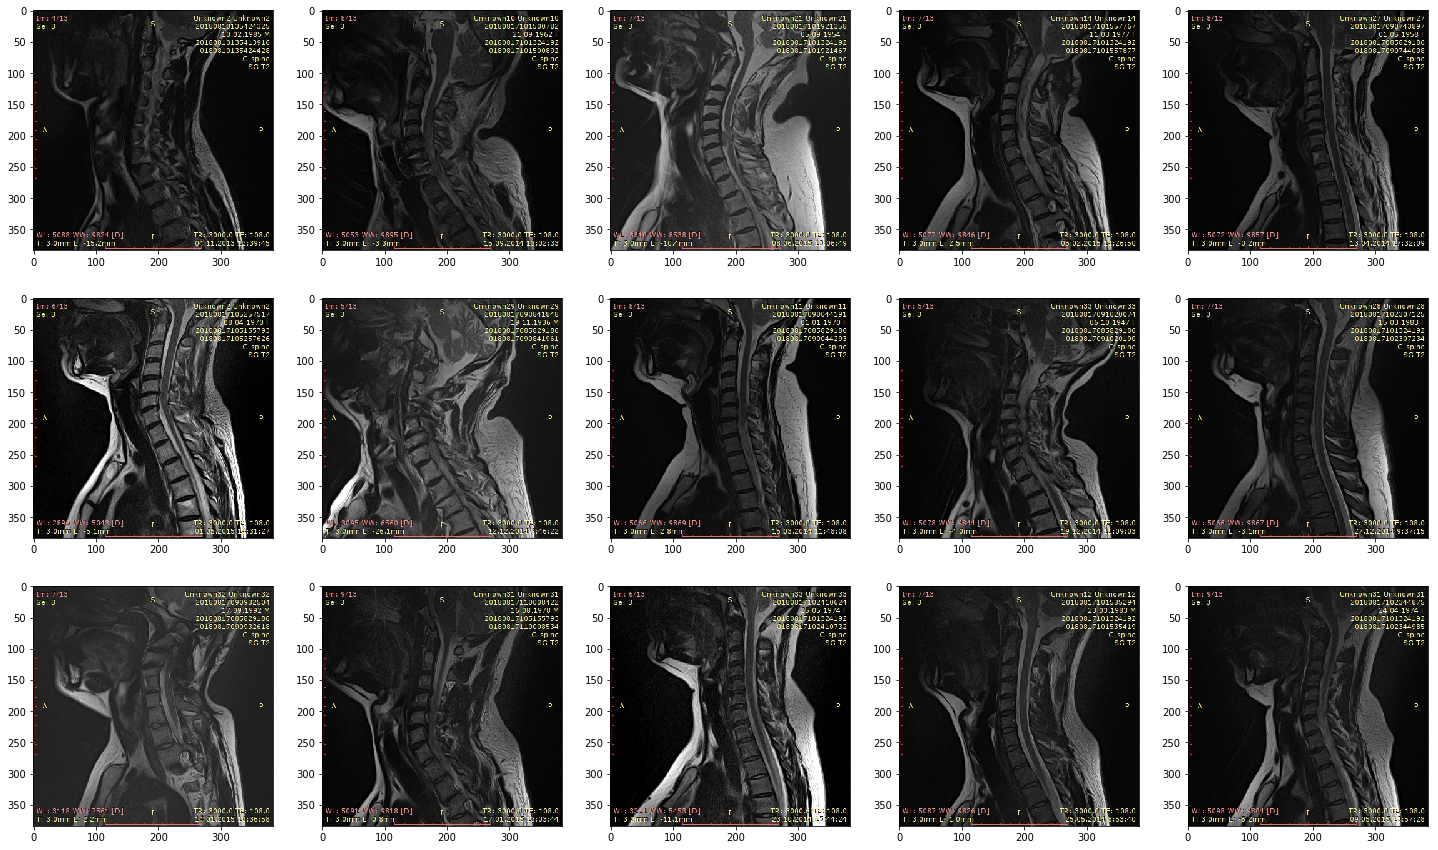

In [16]:
plot_img_classes(row=3, col=5, show_taret=False)

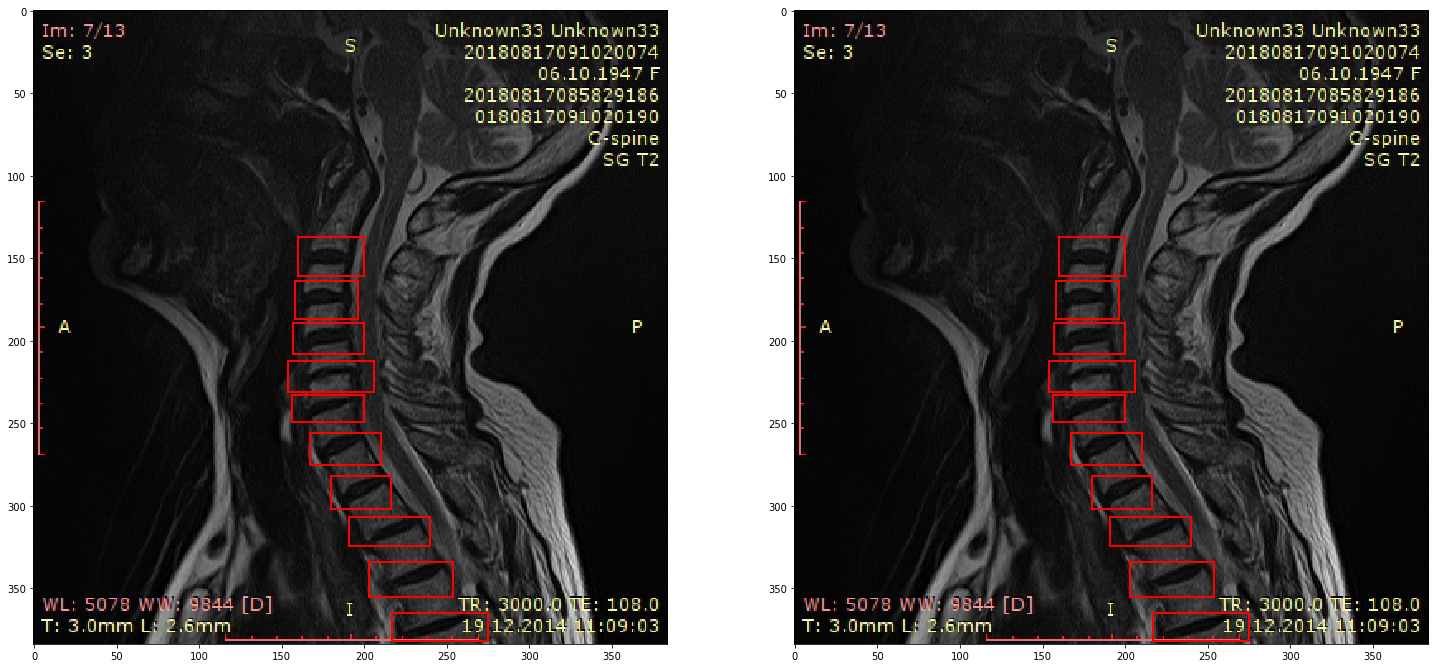

In [17]:
plot_img_classes(row=1, col=2, show_taret=True, image='img_01280.jpg')

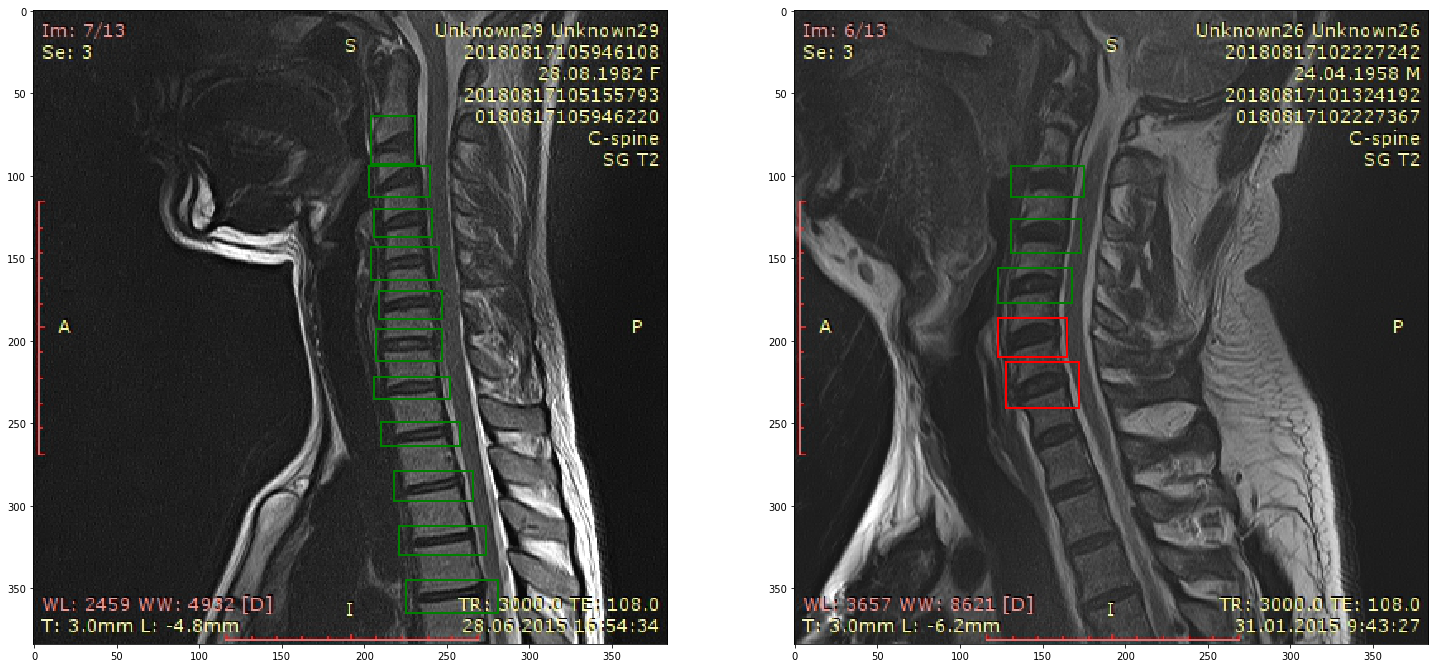

In [18]:
plot_img_classes(row=1, col=2, show_taret=True)

### Выводы:
- все снимки сделаны с одного ракурса (оператор устанавливает пациента в аппарат строго в определенном ракурсе) и вариативность признаков очень малеьнкая, что хорошо
- по этой же причине большого смысла в агументации в виде поворотов снимков нет
- размер картинок разный
- колво людей делающих разметку 3 человека, это возможно мало для точного результата (проверку на пересечения для упрощения не делаю)  
- данных очень мало (356 размеченных картинок) и на серьезный результат расчитывать не приходиться
- присутствуют дубликаты картинок

### <center>CREATE DATASET

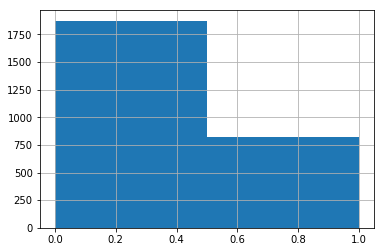

In [19]:
#TARGET CLASS DISTRIBUTION
parsed_xml[['Target names', 'Img size rows', 'Img size cols']] = parsed_xml[['Target names', 'Img size rows', 'Img size cols']].astype(int)
parsed_xml['Target names'].hist(bins=2)

### Меняем последовательность координат на правильную

Из-за особенностей разметки - выделения полигонов людьми размечающими данные (например: квадрат может быть выделен снизу вверх или сверху вниз или сбоку),коррдинаты точек могут идти в разной последовательности.
Необходимо их привести к следующей нотации: 
- 1-я координата - верхняя левая
- 2-я верхняя правая
- 3-я нижняя правая
- 4-я нижняя левая
<br>при условии origin='upper'

In [20]:
#CHECK CONSISTENCE OF COORDINATES
# P0 *-----* P1
#    |     |
#    |     |
# P3 *-----* P2
from operator import itemgetter

max_LOT = lambda lst: max(lst,key=itemgetter(1)) # List Of Tuple
min_LOT = lambda lst: min(lst,key=itemgetter(1))

not_consistence = lambda list_of_P:  list_of_P[0]!=min(list_of_P) and list_of_P[2]!=max(list_of_P)
not_consistence_count = lambda x: sum(list(map(not_consistence, x)))
print('Кол-во неконсистентных координат: ', not_consistence_count(parsed_xml['B boxes']))


parsed_xml['B boxes'] = \
                      [[(min(list(zip(*P))[0]), min(list(zip(*P))[1])), 
                      (max(list(zip(*P))[0]), min(list(zip(*P))[1])), 
                       (max(list(zip(*P))[0]), max(list(zip(*P))[1])), 
                      (min(list(zip(*P))[0]), max(list(zip(*P))[1])) ] for i,P in parsed_xml['B boxes'].items()]

assert not_consistence_count(parsed_xml['B boxes']) == 0, 'Порядок точек не консистентен'

Кол-во неконсистентных координат:  1313


### Балансировка выборки:
выборку необходимо сбалансировать по следующим признакам:
- таргет классы
- люди размечающие данные
- дублированным файлам
- глубине снимка (для упрощения делать не буду)
- машине делающей снимок (для упрощения делать не буду)

In [22]:
#FIND IMAGES WITH THE SAME COUNTS OF TARGET CLASSES 
image_clases = parsed_xml.loc[:,['Files', 'Target names']].groupby(by='Files').sum()
image_clases.rename(columns={'Target names': 'Target sum'}, inplace=True)
#ADD IMAGE CLASES TO parsed_xml
parsed_xml = pd.merge(parsed_xml, image_clases, how='left', on='Files')
print("Частота Таргет класса в разметке каждой картинки")
Counter(image_clases['Target sum'])

Частота Таргет класса в разметке каждой картинки


Counter({4: 41,
         2: 73,
         3: 72,
         1: 48,
         0: 80,
         5: 28,
         6: 5,
         8: 2,
         7: 2,
         9: 3,
         10: 2})

In [23]:
#HOW MANY TIMES RESEARCHERS MARK EACH TARGET CLASS
print(pd.crosstab(parsed_xml['Target names'], parsed_xml['Researcher']))
parsed_xml['Researcher'].value_counts()

Researcher    Denis Shpak  Ilya Gusev  Ruslan Panasenko
Target names                                           
0                     156         929               788
1                     121         288               412


Ilya Gusev          1217
Ruslan Panasenko    1200
Denis Shpak          277
Name: Researcher, dtype: int64

 На этом шаге создаем псевдо класс который включает всебя субклассы: 
 - Таргет классы, 
 - Исследователи, 
 - Кол-во таргет классов на одной картинке

In [24]:
# ADDING PSEUDO CLASS WITCH CONSOLIDATE 3 classes for dataset balancing
parsed_xml['Pseudo_classes'] = parsed_xml[['Target names', 'Researcher', 'Target sum']].apply(lambda x: str(x[0])+' '+x[1]+' '+str(x[2]), axis=1)
pseudo_cl_distr = parsed_xml['Pseudo_classes'].value_counts()
print('Total classes: {0}\nPseudoclass counts:\n\n{1}'.format(len(pseudo_cl_distr), pseudo_cl_distr))

Total classes: 45
Pseudoclass counts:

0 Ilya Gusev 0          477
0 Ruslan Panasenko 2    216
0 Ruslan Panasenko 1    213
0 Ilya Gusev 3          141
0 Ruslan Panasenko 3    133
0 Ilya Gusev 2          132
1 Ruslan Panasenko 3    120
0 Ruslan Panasenko 0     96
0 Ruslan Panasenko 4     83
1 Ruslan Panasenko 4     76
1 Ruslan Panasenko 2     74
1 Ilya Gusev 3           72
1 Ilya Gusev 5           70
0 Ilya Gusev 5           61
1 Ruslan Panasenko 5     60
0 Ilya Gusev 1           58
0 Ilya Gusev 4           55
0 Denis Shpak 2          53
0 Denis Shpak 0          52
1 Ilya Gusev 4           48
1 Denis Shpak 4          40
1 Ilya Gusev 2           38
1 Ruslan Panasenko 1     35
1 Denis Shpak 2          34
0 Ruslan Panasenko 5     29
1 Ilya Gusev 9           27
1 Denis Shpak 3          24
0 Denis Shpak 1          24
1 Ruslan Panasenko 6     24
1 Ilya Gusev 10          20
1 Ruslan Panasenko 8     16
0 Denis Shpak 3          14
0 Ruslan Panasenko 6     13
0 Denis Shpak 4          12
1 Denis S

### Подгоняем размеры полигонов под размер сети

In [25]:
parsed_xml['B boxes'] = [[(int(v[0]*224/item['Img size rows']), 
                           int(v[1]*224/item['Img size cols'])) for v in item['B boxes']] 
                                                                for i, item in parsed_xml.iterrows()]

### Выделяем дубликаты картинок в трейн

In [26]:
#FIND DUBLICATED IMAGES
dublicated_img = parsed_xml.loc[parsed_xml['Files'].isin(list(image_dublicates[0])),:]
#drop dublicates
parsed_xml = parsed_xml.loc[~parsed_xml['Files'].isin(list(image_dublicates[0])),:] 
#EXTRACT PSEUDOCLASS WITH 1 INSTANCE
train_pseudo_class = parsed_xml.loc[parsed_xml['Pseudo_classes']=='0 Ilya Gusev 9']
#drop
parsed_xml = parsed_xml.loc[parsed_xml['Pseudo_classes']!='0 Ilya Gusev 9']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(parsed_xml, parsed_xml['Target names'], stratify=parsed_xml['Pseudo_classes'], test_size=0.33, random_state=42)

In [28]:
X_train = pd.concat([X_train, dublicated_img, train_pseudo_class, ], axis=0)
y_train = X_train['Target names']

### Create dataset for Model data generator
#### in CSV format: "path/to/image.jpg,x1,y1,x2,y2,class_name"

In [29]:
create_dataset = lambda data_frame: \
    df({
        'Image file': data_frame['Files'].map(lambda file_name: IMAGES_DIR+file_name),
                'x1': data_frame['B boxes'].map(lambda x: x[0][0]),
                'y1': data_frame['B boxes'].map(lambda x: x[0][1]),
                'x2': data_frame['B boxes'].map(lambda x: x[2][0]),
                'y2': data_frame['B boxes'].map(lambda x: x[2][1]),
        'Class name': data_frame['Target names'].map(lambda x: 'Healthy' if x==0 else 'Ill')
    })

create_dataset(X_train).to_csv('train_annotations.csv', header=False, index=False)
create_dataset(X_train).to_csv('valid_annotations.csv', header=False, index=False)
data_frame = df({'Class': ['Healthy', 'Ill'], 'Id':[0,1]}).to_csv('classes.csv', header=False, index=False)